In [1]:
import os
os.chdir('..')
from notebooks import config
import numpy as np
import torch
import time
import random
import glob
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
from utils.metric import oa_binary, miou_binary
from utils.imgShow import imsShow
from dataloader.preprocess import read_normalize
# from model.seg_model.model_single_in import unet
from model.seg_model.deeplabv3_plus import deeplabv3plus, deeplabv3plus_imp
from dataloader.parallel_loader import threads_scene_dset
from dataloader.loader import patch_tensor_dset


In [2]:
# ----------- Device --------------- #
device = torch.device('cuda:1')

# ---------- setting ------- #
torch.manual_seed(999)   # make the trianing replicable


In [3]:
# ---------- Data paths ----------- #
paths_as = sorted(glob.glob(config.dir_as + '/*pad*'))
paths_des = sorted(glob.glob(config.dir_des+'/*pad*'))
paths_truth = sorted(glob.glob(config.dir_truth+'/*pad*'))
paths_patch_val = sorted(glob.glob(config.dir_patch_val+'/*'))
print(paths_as[0])


/home/yons/Desktop/developer-luo/Monthly-Surface-Water-in-Tibet/data/dset/s1_ascend/scene01_s1as_pad.tif


In [4]:
'''--------- data loading --------'''
### ------ 1. training data loading: from scenes path ----- ### 
### 1.1. training scenes selection (in the application, all scenes are used for training.)
tra_scenes, tra_truths = read_normalize(paths_as=paths_as, paths_des=paths_des, \
                      paths_truth=paths_truth, max_bands=config.s1_max, min_bands=config.s1_min)
# ### !!!!extract either ascending or descending image.
# tra_scene = [s[2:4] for s in tra_scenes]        ## [0:2] -> ascending; [2:4] -> descending

### 1.2. training data loading
tra_scenes = [tra_scenes[id] for id in config.tra_ids]    ## select the training scenes
tra_truths = [tra_truths[id] for id in config.tra_ids]
tra_dset = threads_scene_dset(scene_list = tra_scenes, \
                              truth_list = tra_truths, 
                              transforms=config.transforms_tra, 
                              num_thread=30)

### ----- 2. val data loading: from prepared validation patches ------ ###
patch_list_val = [torch.load(path) for path in paths_patch_val]
# !!!extract either ascending or descending image for validation
# for i in range(len(patch_list_val)):
#    for j in range(len(patch_list_val[0][0])):
      # patch_list_val[i][0][j] = patch_list_val[i][0][j][2:4]   ## [0:2] -> ascending; [2:4] -> descending
   #   patch_list_val[i][0][j][0:2] = 0   ## [0:2] is ascending; and [2:4] is descending

val_dset = patch_tensor_dset(patch_pair_list = patch_list_val)

### ------- print ------- ###
print('size of training data:', tra_dset.__len__())
print('size of val data:', val_dset.__len__())


size of training data: 840
size of val data: 450


In [5]:
tra_loader = torch.utils.data.DataLoader(tra_dset, \
                                batch_size=config.batch_size, shuffle=True)

val_loader = torch.utils.data.DataLoader(val_dset, batch_size=16)


In [6]:
## ------------ Model ------------ ##
## -------- 1. single scale -------
# model = unet(num_bands=4, num_classes=2).to(device)
model = deeplabv3plus(num_bands=4, num_classes=2).to(device)
# model = deeplabv3plus_imp(num_bands=4, num_classes=2).to(device)


In [7]:
optimizer = torch.optim.Adam(model.parameters(), lr=config.lr)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,\
                                            mode='min', factor=0.5, patience=10)


In [11]:
'''------train step------'''
def train_step(model, loss_fn, optimizer, x, y):
    optimizer.zero_grad()
    pred = model(x)
    loss = loss_fn(pred, y.float())
    loss.backward()
    optimizer.step()
    miou = miou_binary(pred=pred, truth=y)
    oa = oa_binary(pred=pred, truth=y)
    return loss, miou, oa

'''------validation step------'''
def val_step(model, loss_fn, x, y):
    model.eval()
    with torch.no_grad():
        pred = model(x)
        loss = loss_fn(pred, y.float())
    miou = miou_binary(pred=pred, truth=y)
    oa = oa_binary(pred=pred, truth=y)
    return loss, miou, oa

'''------ train loops ------'''
def train_loops(model, loss_fn, optimizer, tra_loader, val_loader, epoches, lr_scheduler):
    size_tra_loader = len(tra_loader)
    size_val_loader = len(val_loader)
    tra_loss_loops, tra_miou_loops = [], []
    val_loss_loops, val_miou_loops = [], []
    for epoch in range(epoches):
        start = time.time()
        tra_loss, val_loss = 0, 0
        tra_miou, val_miou = 0, 0
        tra_oa, val_oa = 0, 0

        '''----- 1. train the model -----'''
        for x_batch, y_batch in tra_loader:
            x_batch, y_batch = x_batch[2].to(device), y_batch.to(device)
            y_batch = config.label_smooth(y_batch, 0.1)         ### --- label smoothing
            loss, miou, oa = train_step(model=model, loss_fn=loss_fn, 
                                            optimizer=optimizer, x=x_batch, y=y_batch)
            tra_loss += loss.item()
            tra_miou += miou.item()
            tra_oa += oa.item()
        lr_scheduler.step(tra_loss)    # dynamic adjust learning rate

        '''----- 2. validate the model -----'''
        for x_batch, y_batch in val_loader:
            x_batch = x_batch[2].to(device).to(dtype=torch.float32)   # fine scale
            y_batch = y_batch.to(device).to(dtype=torch.float32)

            loss, miou, oa = val_step(model=model, loss_fn=loss_fn, \
                                                        x=x_batch, y=y_batch)
            val_loss += loss.item()
            val_miou += miou.item()
            val_oa += oa.item()

        '''------ 3. print accuracy ------'''
        tra_loss = tra_loss/size_tra_loader
        val_loss = val_loss/size_val_loader
        tra_miou = tra_miou/size_tra_loader
        val_miou = val_miou/size_val_loader
        tra_oa = tra_oa/size_tra_loader
        val_oa = val_oa/size_val_loader
        tra_loss_loops.append(tra_loss), tra_miou_loops.append(tra_miou)
        val_loss_loops.append(val_loss), val_miou_loops.append(val_miou)

        format = 'Ep{}: tra-> Loss:{:.3f},Oa:{:.3f},Miou:{:.3f}, val-> Loss:{:.3f},Oa:{:.3f},Miou:{:.3f},time:{:.1f}s'
        print(format.format(epoch+1, tra_loss, tra_oa, tra_miou, val_loss, val_oa, val_miou, time.time()-start))

        '''------- 4. visualize the result -------'''
        if (epoch+1)%10 == 0:
            model.eval()
            sam_index = random.randrange(len(val_dset))
            patches, truth = val_dset[sam_index]
            patch = torch.unsqueeze(patches[2], 0).to(device).to(dtype=torch.float32)   # 
            truth = truth.to(device)
            pred = model(patch)
            patch = patch[0].to('cpu').detach().numpy().transpose(1,2,0)
            pred = pred[0].to('cpu').detach().numpy()
            truth = truth.to('cpu').detach().numpy()
            pred = np.where(pred>0.5, 1, 0)
            patch_list = [patch, truth, pred]
            # ---- plot result
            plt.figure(figsize=(8,4))
            patches_name = ['input','truth','pred']
            clip_list = [2,0,0]
            col_bands_list = [(2,1,0), (0,0,0), (0,0,0)]
            imsShow(img_list=patch_list, img_name_list=patches_name, \
                                        clip_list=clip_list, color_bands_list=col_bands_list)
            plt.show()

    metrics = {'tra_loss':tra_loss_loops, 'tra_miou':tra_miou_loops, 'val_loss': val_loss_loops, 'val_miou': val_miou_loops}
    return metrics
    

Ep1: tra-> Loss:0.479,Oa:0.566,Miou:0.470, val-> Loss:0.465,Oa:0.397,Miou:0.397,time:16.3s
Ep2: tra-> Loss:0.412,Oa:0.650,Miou:0.556, val-> Loss:0.355,Oa:0.771,Miou:0.621,time:16.0s
Ep3: tra-> Loss:0.413,Oa:0.734,Miou:0.616, val-> Loss:0.370,Oa:0.819,Miou:0.599,time:16.7s
Ep4: tra-> Loss:0.413,Oa:0.732,Miou:0.598, val-> Loss:0.386,Oa:0.777,Miou:0.544,time:16.7s
Ep5: tra-> Loss:0.403,Oa:0.714,Miou:0.589, val-> Loss:0.384,Oa:0.743,Miou:0.546,time:17.0s
Ep6: tra-> Loss:0.413,Oa:0.704,Miou:0.585, val-> Loss:0.391,Oa:0.755,Miou:0.459,time:16.5s
Ep7: tra-> Loss:0.407,Oa:0.689,Miou:0.578, val-> Loss:0.405,Oa:0.774,Miou:0.582,time:16.5s
Ep8: tra-> Loss:0.415,Oa:0.726,Miou:0.610, val-> Loss:0.387,Oa:0.691,Miou:0.533,time:16.1s
Ep9: tra-> Loss:0.422,Oa:0.742,Miou:0.626, val-> Loss:0.360,Oa:0.813,Miou:0.557,time:17.2s
Ep10: tra-> Loss:0.416,Oa:0.734,Miou:0.602, val-> Loss:0.380,Oa:0.811,Miou:0.477,time:16.8s


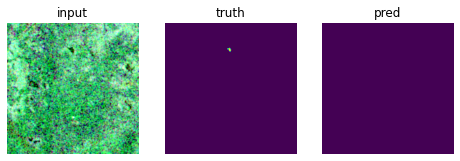

Ep11: tra-> Loss:0.408,Oa:0.727,Miou:0.617, val-> Loss:0.384,Oa:0.734,Miou:0.551,time:16.3s
Ep12: tra-> Loss:0.419,Oa:0.702,Miou:0.576, val-> Loss:0.404,Oa:0.740,Miou:0.525,time:16.3s
Ep13: tra-> Loss:0.407,Oa:0.702,Miou:0.586, val-> Loss:0.360,Oa:0.743,Miou:0.562,time:16.3s
Ep14: tra-> Loss:0.400,Oa:0.726,Miou:0.615, val-> Loss:0.436,Oa:0.711,Miou:0.429,time:16.7s
Ep15: tra-> Loss:0.399,Oa:0.702,Miou:0.593, val-> Loss:0.356,Oa:0.819,Miou:0.565,time:16.2s
Ep16: tra-> Loss:0.401,Oa:0.720,Miou:0.564, val-> Loss:0.362,Oa:0.827,Miou:0.592,time:16.3s
Ep17: tra-> Loss:0.411,Oa:0.714,Miou:0.591, val-> Loss:0.425,Oa:0.746,Miou:0.436,time:16.2s
Ep18: tra-> Loss:0.407,Oa:0.734,Miou:0.606, val-> Loss:0.337,Oa:0.823,Miou:0.588,time:16.4s
Ep19: tra-> Loss:0.406,Oa:0.764,Miou:0.609, val-> Loss:0.343,Oa:0.798,Miou:0.667,time:16.6s
Ep20: tra-> Loss:0.415,Oa:0.720,Miou:0.585, val-> Loss:0.341,Oa:0.825,Miou:0.601,time:16.3s


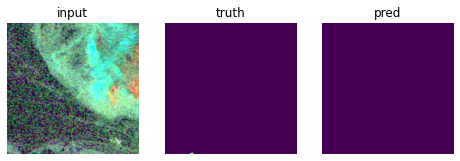

Ep21: tra-> Loss:0.409,Oa:0.742,Miou:0.607, val-> Loss:0.355,Oa:0.784,Miou:0.514,time:17.0s
Ep22: tra-> Loss:0.399,Oa:0.738,Miou:0.629, val-> Loss:0.334,Oa:0.780,Miou:0.578,time:16.5s
Ep23: tra-> Loss:0.396,Oa:0.747,Miou:0.632, val-> Loss:0.337,Oa:0.771,Miou:0.655,time:16.2s
Ep24: tra-> Loss:0.400,Oa:0.716,Miou:0.602, val-> Loss:0.438,Oa:0.656,Miou:0.512,time:16.7s
Ep25: tra-> Loss:0.409,Oa:0.673,Miou:0.573, val-> Loss:0.454,Oa:0.698,Miou:0.489,time:16.5s
Ep26: tra-> Loss:0.405,Oa:0.679,Miou:0.582, val-> Loss:0.397,Oa:0.774,Miou:0.548,time:16.6s
Ep27: tra-> Loss:0.397,Oa:0.740,Miou:0.619, val-> Loss:0.427,Oa:0.805,Miou:0.548,time:16.3s
Ep28: tra-> Loss:0.408,Oa:0.742,Miou:0.607, val-> Loss:0.382,Oa:0.839,Miou:0.598,time:16.7s
Ep29: tra-> Loss:0.395,Oa:0.714,Miou:0.607, val-> Loss:0.369,Oa:0.808,Miou:0.562,time:16.5s
Ep30: tra-> Loss:0.397,Oa:0.750,Miou:0.615, val-> Loss:0.403,Oa:0.820,Miou:0.535,time:16.9s


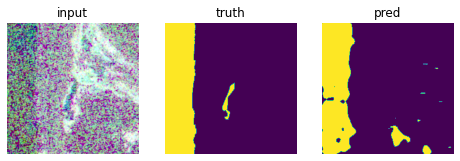

Ep31: tra-> Loss:0.400,Oa:0.722,Miou:0.593, val-> Loss:0.360,Oa:0.802,Miou:0.591,time:16.7s
Ep32: tra-> Loss:0.397,Oa:0.745,Miou:0.634, val-> Loss:0.381,Oa:0.754,Miou:0.579,time:16.7s
Ep33: tra-> Loss:0.408,Oa:0.774,Miou:0.641, val-> Loss:0.355,Oa:0.756,Miou:0.659,time:16.5s
Ep34: tra-> Loss:0.411,Oa:0.762,Miou:0.643, val-> Loss:0.323,Oa:0.794,Miou:0.641,time:16.5s
Ep35: tra-> Loss:0.407,Oa:0.738,Miou:0.618, val-> Loss:0.354,Oa:0.837,Miou:0.581,time:16.7s
Ep36: tra-> Loss:0.404,Oa:0.779,Miou:0.610, val-> Loss:0.316,Oa:0.766,Miou:0.645,time:17.0s
Ep37: tra-> Loss:0.406,Oa:0.726,Miou:0.604, val-> Loss:0.417,Oa:0.737,Miou:0.531,time:16.5s
Ep38: tra-> Loss:0.410,Oa:0.693,Miou:0.561, val-> Loss:0.355,Oa:0.741,Miou:0.583,time:16.7s
Ep39: tra-> Loss:0.395,Oa:0.778,Miou:0.651, val-> Loss:0.362,Oa:0.798,Miou:0.596,time:16.4s
Ep40: tra-> Loss:0.396,Oa:0.775,Miou:0.640, val-> Loss:0.373,Oa:0.744,Miou:0.579,time:16.6s


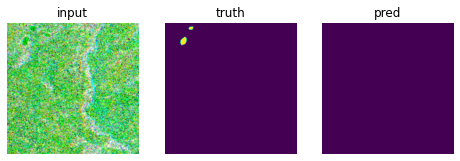

Ep41: tra-> Loss:0.410,Oa:0.740,Miou:0.580, val-> Loss:0.388,Oa:0.798,Miou:0.549,time:16.4s
Ep42: tra-> Loss:0.401,Oa:0.724,Miou:0.581, val-> Loss:0.421,Oa:0.839,Miou:0.462,time:16.5s
Ep43: tra-> Loss:0.389,Oa:0.785,Miou:0.628, val-> Loss:0.365,Oa:0.830,Miou:0.603,time:16.5s
Ep44: tra-> Loss:0.397,Oa:0.770,Miou:0.645, val-> Loss:0.425,Oa:0.745,Miou:0.489,time:16.5s
Ep45: tra-> Loss:0.405,Oa:0.720,Miou:0.592, val-> Loss:0.378,Oa:0.752,Miou:0.567,time:16.4s
Ep46: tra-> Loss:0.408,Oa:0.753,Miou:0.614, val-> Loss:0.371,Oa:0.755,Miou:0.576,time:16.8s
Ep47: tra-> Loss:0.398,Oa:0.755,Miou:0.623, val-> Loss:0.323,Oa:0.758,Miou:0.595,time:16.4s
Ep48: tra-> Loss:0.388,Oa:0.754,Miou:0.645, val-> Loss:0.321,Oa:0.808,Miou:0.637,time:16.6s
Ep49: tra-> Loss:0.400,Oa:0.786,Miou:0.651, val-> Loss:0.380,Oa:0.800,Miou:0.551,time:16.6s
Ep50: tra-> Loss:0.391,Oa:0.781,Miou:0.644, val-> Loss:0.335,Oa:0.800,Miou:0.641,time:16.6s


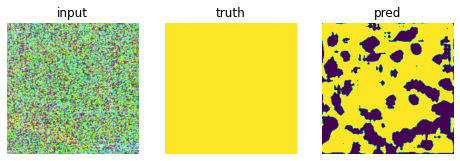

Ep51: tra-> Loss:0.394,Oa:0.752,Miou:0.600, val-> Loss:0.455,Oa:0.798,Miou:0.471,time:16.5s
Ep52: tra-> Loss:0.390,Oa:0.752,Miou:0.630, val-> Loss:0.348,Oa:0.800,Miou:0.582,time:16.3s
Ep53: tra-> Loss:0.385,Oa:0.793,Miou:0.651, val-> Loss:0.335,Oa:0.778,Miou:0.626,time:16.6s
Ep54: tra-> Loss:0.399,Oa:0.766,Miou:0.626, val-> Loss:0.396,Oa:0.808,Miou:0.475,time:16.5s
Ep55: tra-> Loss:0.401,Oa:0.720,Miou:0.588, val-> Loss:0.352,Oa:0.862,Miou:0.599,time:16.4s
Ep56: tra-> Loss:13.720,Oa:0.480,Miou:0.449, val-> Loss:20.571,Oa:0.397,Miou:0.397,time:16.4s
Ep57: tra-> Loss:17.410,Oa:0.454,Miou:0.454, val-> Loss:20.571,Oa:0.397,Miou:0.397,time:16.1s
Ep58: tra-> Loss:16.915,Oa:0.457,Miou:0.457, val-> Loss:20.571,Oa:0.397,Miou:0.397,time:16.8s
Ep59: tra-> Loss:18.052,Oa:0.450,Miou:0.450, val-> Loss:20.571,Oa:0.397,Miou:0.397,time:16.5s
Ep60: tra-> Loss:17.319,Oa:0.454,Miou:0.454, val-> Loss:20.571,Oa:0.397,Miou:0.397,time:16.3s


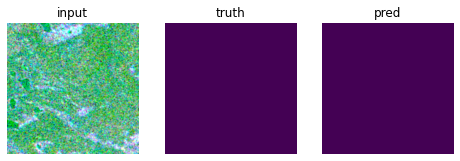

Ep61: tra-> Loss:18.764,Oa:0.445,Miou:0.445, val-> Loss:20.571,Oa:0.397,Miou:0.397,time:16.5s
Ep62: tra-> Loss:18.300,Oa:0.448,Miou:0.448, val-> Loss:20.571,Oa:0.397,Miou:0.397,time:16.4s
Ep63: tra-> Loss:18.918,Oa:0.444,Miou:0.444, val-> Loss:20.571,Oa:0.397,Miou:0.397,time:16.7s
Ep64: tra-> Loss:17.118,Oa:0.456,Miou:0.456, val-> Loss:20.571,Oa:0.397,Miou:0.397,time:16.8s
Ep65: tra-> Loss:17.866,Oa:0.451,Miou:0.451, val-> Loss:20.571,Oa:0.397,Miou:0.397,time:16.7s
Ep66: tra-> Loss:16.897,Oa:0.457,Miou:0.457, val-> Loss:20.571,Oa:0.397,Miou:0.397,time:16.1s
Ep67: tra-> Loss:17.530,Oa:0.453,Miou:0.453, val-> Loss:20.571,Oa:0.397,Miou:0.397,time:16.8s
Ep68: tra-> Loss:17.593,Oa:0.453,Miou:0.453, val-> Loss:20.571,Oa:0.397,Miou:0.397,time:16.4s
Ep69: tra-> Loss:16.788,Oa:0.458,Miou:0.458, val-> Loss:20.571,Oa:0.397,Miou:0.397,time:16.5s
Ep70: tra-> Loss:18.126,Oa:0.449,Miou:0.449, val-> Loss:20.571,Oa:0.397,Miou:0.397,time:16.5s


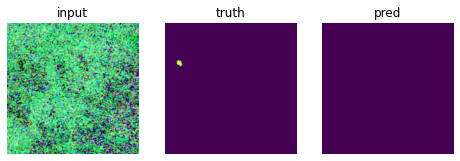

Ep71: tra-> Loss:17.061,Oa:0.456,Miou:0.456, val-> Loss:20.571,Oa:0.397,Miou:0.397,time:16.5s
Ep72: tra-> Loss:16.800,Oa:0.457,Miou:0.457, val-> Loss:20.571,Oa:0.397,Miou:0.397,time:16.3s
Ep73: tra-> Loss:17.481,Oa:0.453,Miou:0.453, val-> Loss:20.571,Oa:0.397,Miou:0.397,time:16.1s
Ep74: tra-> Loss:16.858,Oa:0.457,Miou:0.457, val-> Loss:20.571,Oa:0.397,Miou:0.397,time:16.5s
Ep75: tra-> Loss:17.531,Oa:0.453,Miou:0.453, val-> Loss:20.571,Oa:0.397,Miou:0.397,time:16.7s
Ep76: tra-> Loss:17.737,Oa:0.452,Miou:0.452, val-> Loss:20.571,Oa:0.397,Miou:0.397,time:16.4s
Ep77: tra-> Loss:16.451,Oa:0.460,Miou:0.460, val-> Loss:20.571,Oa:0.397,Miou:0.397,time:16.3s
Ep78: tra-> Loss:16.693,Oa:0.458,Miou:0.458, val-> Loss:20.571,Oa:0.397,Miou:0.397,time:16.7s
Ep79: tra-> Loss:16.457,Oa:0.460,Miou:0.460, val-> Loss:20.571,Oa:0.397,Miou:0.397,time:16.5s
Ep80: tra-> Loss:17.387,Oa:0.454,Miou:0.454, val-> Loss:20.571,Oa:0.397,Miou:0.397,time:16.6s


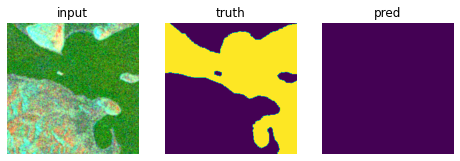

Ep81: tra-> Loss:18.047,Oa:0.450,Miou:0.450, val-> Loss:20.571,Oa:0.397,Miou:0.397,time:16.4s
Ep82: tra-> Loss:17.945,Oa:0.450,Miou:0.450, val-> Loss:20.571,Oa:0.397,Miou:0.397,time:16.8s
Ep83: tra-> Loss:18.182,Oa:0.449,Miou:0.449, val-> Loss:20.571,Oa:0.397,Miou:0.397,time:16.5s
Ep84: tra-> Loss:17.313,Oa:0.454,Miou:0.454, val-> Loss:20.571,Oa:0.397,Miou:0.397,time:16.7s
Ep85: tra-> Loss:18.711,Oa:0.446,Miou:0.446, val-> Loss:20.571,Oa:0.397,Miou:0.397,time:16.9s
Ep86: tra-> Loss:18.617,Oa:0.446,Miou:0.446, val-> Loss:20.571,Oa:0.397,Miou:0.397,time:16.5s
Ep87: tra-> Loss:16.664,Oa:0.458,Miou:0.458, val-> Loss:20.571,Oa:0.397,Miou:0.397,time:16.4s
Ep88: tra-> Loss:17.672,Oa:0.452,Miou:0.452, val-> Loss:20.571,Oa:0.397,Miou:0.397,time:16.5s
Ep89: tra-> Loss:17.138,Oa:0.455,Miou:0.455, val-> Loss:20.571,Oa:0.397,Miou:0.397,time:16.3s
Ep90: tra-> Loss:17.114,Oa:0.456,Miou:0.456, val-> Loss:20.571,Oa:0.397,Miou:0.397,time:16.4s


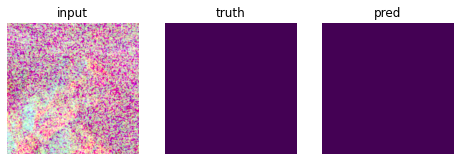

Ep91: tra-> Loss:17.250,Oa:0.455,Miou:0.455, val-> Loss:20.571,Oa:0.397,Miou:0.397,time:16.6s
Ep92: tra-> Loss:17.601,Oa:0.452,Miou:0.452, val-> Loss:20.571,Oa:0.397,Miou:0.397,time:16.3s
Ep93: tra-> Loss:17.291,Oa:0.454,Miou:0.454, val-> Loss:20.571,Oa:0.397,Miou:0.397,time:16.5s
Ep94: tra-> Loss:16.592,Oa:0.459,Miou:0.459, val-> Loss:20.571,Oa:0.397,Miou:0.397,time:16.7s


In [12]:
metrics = train_loops(model=model,  
                    loss_fn=config.loss_bce,  
                    optimizer=optimizer,  
                    tra_loader=tra_loader,  
                    val_loader=val_loader,  
                    epoches=config.epoch,   
                    lr_scheduler=lr_scheduler)


## Model and metrics saving


In [ ]:
# model_name = 'model_single_test_11'
# # model save/load
# model_weights = config.root_proj + '/model/pretrained/model_single_test/' + model_name + '_weights.pth'
# torch.save(model.state_dict(), model_weights)
# # model.load_state_dict(torch.load(model_weights))


In [ ]:
# ## metrics saving
# metrics_path = config.root_proj + '/model/pretrained/model_single_test/' + model_name + '_metrics.csv'
# metrics_df = pd.DataFrame(metrics)
# metrics_df.to_csv(metrics_path, index=False, sep=',')
# # metrics_df = pd.read_csv(metrics_path)
